<h1><center> COMP551 Mini-Project 4: Reproducibility in ML </center></h1>
<h3><center> Alireza Seyedkanani, Ehsan Estakhrianhaghighi, Mohammadali Rastak  </h3></center>
<h3><center> April 26, 2022 </h3></center>
<center> In this code, the results of the paper <em>Detection of illicit accounts over the Ethereum blockchain</em> have been reproduced. </</center>

# Preamble

We import the required packages.

In [ ]:
# importing the necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from google.colab import files

import time
from collections import Counter

import numpy
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, \
    precision_recall_curve
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans


# T-SNE Scatter Plots

In this section, we reproduce Figures 1 and 2 of the paper, which are 2D and 3D scatter plots of data transformed with t-SNE (T-distributed Stochastic Neighbor Embedding), respectively. It is a way to visualize the dataset to see the overlap of datapoints corresponding to different classes and highlight the necessity of machine learning algorithms to distinguish data points with different classes.

In [ ]:
def read_file(url):

    csv_file_url = url
    df = pd.read_csv(csv_file_url)

    df = remove_fields(df)

    df.fillna(0, inplace=True)
    return df

# Remove unnecessary fields
def remove_fields(df):
    df.pop('Index')
    df.pop('Address')
    df.pop('ERC20_most_sent_token_type')
    df.pop('ERC20_most_rec_token_type')
    df.pop('ERC20_uniq_sent_token_name')
    df.pop('ERC20_uniq_rec_token_name')
    return df

def TSNE_plot_2D(df):
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, n_iter_without_progress=20)
    X = df.loc[:, df.columns != 'FLAG']
    Y = df['FLAG']
    tsne_results = tsne.fit_transform(X)
    X['first_dimension'] = tsne_results[:, 0]
    X['second_dimension'] = tsne_results[:, 1]

    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x='first_dimension', y='second_dimension',
        hue=Y,
        palette=['blue','red'],
        data=X,
        legend="full",
        alpha=0.2
    )
    plt.title('t-SNE 2D scatter plot')
    plt.xlabel('first dimension')
    plt.ylabel('second dimension')
    #plt.savefig('Figure_1.pdf', format='pdf', bbox_inches='tight')
    #files.download('Figure_1.pdf')
    plt.show()

def TSNE_plot_3D(df):
    tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=1000)
    X = df.loc[:, df.columns != 'FLAG']
    X = X.loc[:, :]
    Y = df['FLAG']
    tsne_results = tsne.fit_transform(X)
    X['first_dimension'] = tsne_results[:, 0]
    X['second_dimension'] = tsne_results[:, 1]
    X['third_dimension'] = tsne_results[:,2]

    colors = ['blue', 'red']
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)
    ax.scatter(X['first_dimension'], X['second_dimension'], X['third_dimension'], c=Y,
               marker='o', cmap=matplotlib.colors.ListedColormap(colors))
    ax.view_init(30, 225)
    ax.set_xlabel('first dimension')
    ax.set_ylabel('second dimension')
    ax.set_zlabel('third dimension')
    plt.title('t-SNE 3D scatter plot')
    #plt.savefig('Figure_2.pdf', format='pdf', bbox_inches='tight')
    #files.download('Figure_2.pdf')
    fig.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4681 samples in 0.001s...
[t-SNE] Computed neighbors for 4681 samples in 0.614s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4681
[t-SNE] Computed conditional probabilities for sample 2000 / 4681
[t-SNE] Computed conditional probabilities for sample 3000 / 4681
[t-SNE] Computed conditional probabilities for sample 4000 / 4681
[t-SNE] Computed conditional probabilities for sample 4681 / 4681
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.706795
[t-SNE] KL divergence after 1000 iterations: 0.494606


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

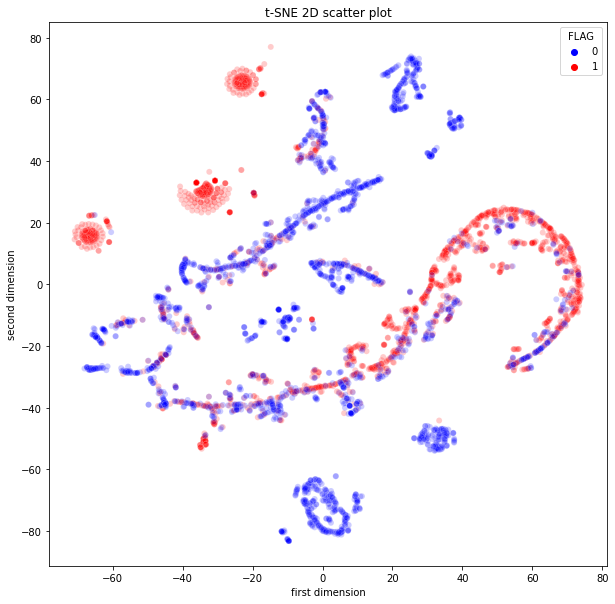

In [ ]:
accounts = read_file('https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv')
TSNE_plot_2D(accounts)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4681 samples in 0.000s...
[t-SNE] Computed neighbors for 4681 samples in 0.585s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4681
[t-SNE] Computed conditional probabilities for sample 2000 / 4681
[t-SNE] Computed conditional probabilities for sample 3000 / 4681
[t-SNE] Computed conditional probabilities for sample 4000 / 4681
[t-SNE] Computed conditional probabilities for sample 4681 / 4681
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.550438
[t-SNE] KL divergence after 1000 iterations: 0.388630


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

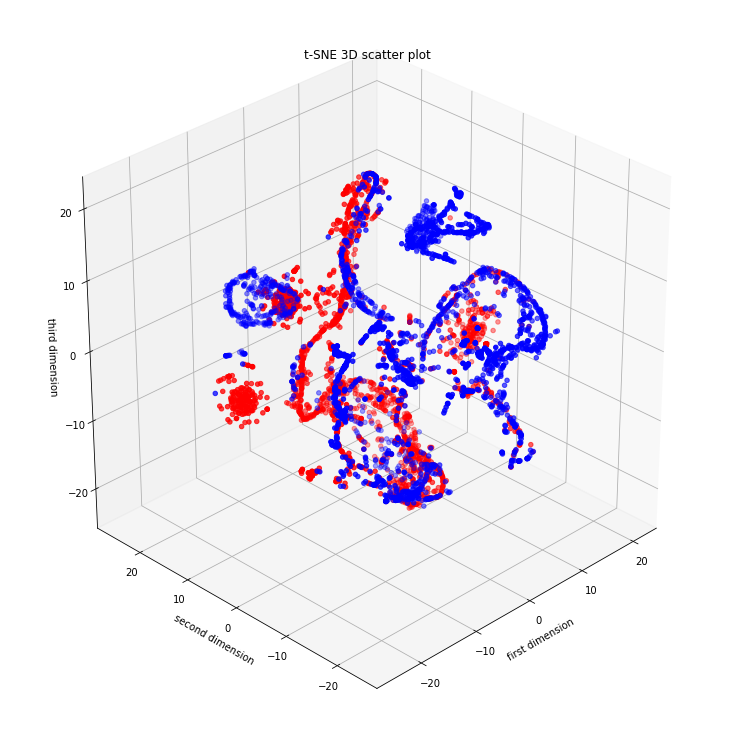

In [ ]:
TSNE_plot_3D(accounts)

# Hyper-parameter Tuning

In this section, we reproduce the results for truned hyper-parameters, i.e. learning rate, number of tress/estimators, and maximum tree depth, for XGBoost algorithm. AUC is used as the measure to determine the optimum model.

In [ ]:
def XGBoost_Classifier (X_train, y_train, X_test, y_test):
    X_train = X_train.loc[:, X_train.columns != 'Address']
    X_test = X_test.loc[:, X_test.columns != 'Address']

    model = xgb.XGBClassifier(max_depth=3,
                              subsample=0.5,
                              objective='binary:logistic',
                              n_estimators=250,
                              learning_rate=0.2)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric=["error", "logloss"],
              eval_set=eval_set, verbose=True)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    # plot log loss
    plt.figure()
    plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
    plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
    plt.legend()
    plt.ylabel('Log Loss')
    plt.xlabel('Number of iterations')
    plt.title('XGBoost Log Loss')
    #plt.savefig('Figure_4.pdf', format='pdf', bbox_inches='tight')
    #files.download('Figure_4.pdf')
    plt.show()
    # plot classification error
    plt.figure()
    plt.plot(x_axis, results['validation_0']['error'], label='Train')
    plt.plot(x_axis, results['validation_1']['error'], label='Test')
    plt.legend()
    plt.ylabel('Classification Error')
    plt.xlabel('Number of iterations')
    plt.title('XGBoost Classification Error')
    #plt.savefig('Figure_5.pdf', format='pdf', bbox_inches='tight')
    #files.download('Figure_5.pdf')
    plt.show()

def XGBoost(X_train, y_train, X_test, y_test):
    model2 = xgb.XGBClassifier(n_estimators=250, max_depth=3, learning_rate=0.2, subsample=0.5, objective='binary:logistic')

    X_train = X_train.loc[:, X_train.columns != 'Address']
    X_test_addresses = X_test['Address']
    X_test = X_test.loc[:, X_test.columns != 'Address']
    X_test_addresses = np.array(X_test_addresses)

    #train_model1 = model1.fit(X_train, y_train)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    train_model2 = model2.fit(X_train, y_train, early_stopping_rounds=100, eval_metric=["error", "logloss"],
              eval_set=eval_set, verbose=False)
    pred2 = train_model2.predict(X_test)
    #print(classification_report(y_test, pred1))
    #print("Accuracy for model 1: %.2f" % (accuracy_score(y_test, pred1) * 100))

    print(classification_report(y_test, pred2))
    print("Accuracy for model 2: %.2f" % (accuracy_score(y_test, pred2) * 100))
    auc = roc_auc_score(y_test, model2.predict_proba(X_test)[:, 1])
    precision, recall, threshold = precision_recall_curve(y_test, model2.predict_proba(X_test)[:, 1])
    #print(threshold)
    print("ROC: " , auc)
    #print([i for i, j in zip(pred2, y_test) if i != j])
    index = 0
    FP = []
    FN = []
    for i,j in zip(pred2, y_test):
        if j == 1:
            if i != j:
                FN.append(X_test_addresses[index])

        if j == 0:
            if i != j:
                FP.append(X_test_addresses[index])
        index += 1

    print("FALSE POSITIVES: ", len(FP))
    print("FALSE NEGATIVES: ", len(FN))

    #plot_FP_FN(FP=FP, FN=FN)

    # Weight - number of times feature is used to split the data across all trees
    # Cover - number of times feature is used to split data across all trees weighted by number of
    #         training data points that go through those splits
    # Gain - average training loss reduction gained when using a feature for splitting

    importance = model2.get_booster().get_score(importance_type='weight')
    importance = sorted(importance.items(), key= lambda l:l[1], reverse=True)

    # Plot non-normalized confusion matrix
    #plot_confusion_matrix(y_test, pred2, classes=np.array(['Normal','Illicit']),
    #                    title='Confusion matrix')

    # # Plot normalized confusion matrix
    # plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
    #                       title='Normalized confusion matrix')

    #plt.savefig('Figure_6.pdf', format='pdf', bbox_inches='tight')
    #files.download('Figure_6.pdf')
    #plt.show()
    return importance

def plot_FP_FN(FP,FN):
    import plotly.plotly as py
    import plotly.graph_objs as go
    py.sign_in('sfarr15', 'W10VRtI3WkpBD8gJmP4R')
    trace = go.Table(
        header=dict(values=['False Positives','False Negatives'],
                    line=dict(color='#7D7F80'),
                    fill=dict(color='#a1c3d1'),
                    align=['left'] * 5),
        cells=dict(values=[FP,
                           FN],
                   line=dict(color='#7D7F80'),
                   fill=dict(color='#EDFAFF'),
                   align=['left'] * 5))

    layout = dict(width=1000, height=900)
    data = [trace]
    fig = dict(data=data, layout=layout)
    py.plot(fig, filename='styled_table')


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(tn, fp, fn, tp)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='true label',
           xlabel='predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def stratified_k_fold_XGBoost(X, Y, n_folds):
    X = X.loc[:, X.columns != 'Address']
    matplotlib.use('Agg')
    print("Starting stratified Cross-validation using XG-Boost")

    model1 = xgb.XGBClassifier(learning_rate=0.2)
    max_depth = [2, 3, 4, 5, 6, 7, 8]
    n_estimators = [100, 150, 200, 250, 300]
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=7)
    scoring = {'auc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'}
    current = time.time()
    results = GridSearchCV(model1, param_grid, cv=kfold, scoring=scoring, refit='auc', n_jobs=-1)
    grid_result = results.fit(X, Y)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means_auc = grid_result.cv_results_['mean_test_auc']
    means_acc = grid_result.cv_results_['mean_test_acc']
    means_f1 = grid_result.cv_results_['mean_test_f1']
    stds_auc = grid_result.cv_results_['std_test_auc']
    stds_acc = grid_result.cv_results_['std_test_acc']
    stds_f1 = grid_result.cv_results_['std_test_f1']
    params = grid_result.cv_results_['params']

    for mean_acc, std_acc, mean_f1, std_f1, mean_auc, std_auc, param in zip(means_acc, stds_acc, means_f1, stds_f1, means_auc, stds_auc, params):
      print('acc = %f (%f) and f1 = %f (%f) and auc = %f (%f) with: %r' % (mean_acc, std_acc, mean_f1, std_f1, mean_auc, std_auc, param))
    print('Execution time: ', time.time() - current)

    # plot results
    scores = np.array(means_auc).reshape(len(max_depth), len(n_estimators))
    for i, value in enumerate(max_depth):
        plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('Average AUC')
    #plt.savefig('Figure_3.pdf', format='pdf', bbox_inches='tight')
    #files.download('Figure_3.pdf')
    plt.show()


def random_forest(X_train, y_train, X_test, y_test):

    X_train = X_train.loc[:, X_train.columns != 'Address']
    X_test = X_test.loc[:, X_test.columns != 'Address']

    rfc = RandomForestClassifier()
    rfc_model = rfc.fit(X_train, y_train)
    pred8 = rfc_model.predict(X_test)
    print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(y_test, pred8) * 100))
    print(classification_report(y_test, pred8))
    roc = roc_auc_score(y_test, rfc_model.predict_proba(X_test)[:, 1])
    print("ROC:" , roc)


def prepare_dataset_split(X, Y, testSize):
    test_size = testSize

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, shuffle=True)
    print("Size of Training: ", len(X_train))
    print("Size of Testing: ", len(X_test))
    return X_train, X_test, y_train, y_test

def get_dataset(url):
    import pandas as pd

    csv_file_url = url
    df = pd.read_csv(csv_file_url)

    Y = df['FLAG']
    X = df.loc[:, df.columns != 'FLAG']
    X.pop('Index')
    X.pop('ERC20_most_sent_token_type')
    X.pop('ERC20_most_rec_token_type')
    X.pop('ERC20_uniq_sent_token_name')
    X.pop('ERC20_uniq_rec_token_name')
    #X.pop('Address')

    X.fillna(0, inplace=True)
    return X, Y

# Returns the total frequency per feature over the number of folds
def update_list(importance_value_list):
    c = Counter()
    for k,v in importance_value_list:
        c[k] += v

    # PLOT TOP 10
    # feature_list = list(c.items())[:10]

    # PLOT ALL
    feature_list = list(c.items())

    sorted_feature_list = sorted(feature_list.__iter__(), key=lambda x : x[1], reverse=False)
    print(sorted_feature_list)

    return sorted_feature_list


def plot_average_importance_values(sorted_feature_list, num_of_train_test):

    key, value = zip(*sorted_feature_list.__iter__())
    value = [int(x / num_of_train_test) for x in value]
    #plt.figure(figsize=(10, 10))
    plt.barh(key[-10:], value[-10:])
    plt.title('Feature importance ranking - Weight')
    plt.xlabel('Frequency')
    plt.ylabel('Features')
    #plt.savefig('Figure_7.pdf', format='pdf', bbox_inches='tight')
    #files.download('Figure_7.pdf')
    plt.show()

## Grid search results with 3-fold CV


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting stratified Cross-validation using XG-Boost
Best: 0.993508 using {'max_depth': 5, 'n_estimators': 200}
acc = 0.951078 (0.003935) and f1 = 0.947406 (0.004353) and auc = 0.990382 (0.001896) with: {'max_depth': 2, 'n_estimators': 100}
acc = 0.953428 (0.003495) and f1 = 0.949880 (0.003806) and auc = 0.991820 (0.001905) with: {'max_depth': 2, 'n_estimators': 150}
acc = 0.954923 (0.005278) and f1 = 0.951571 (0.005656) and auc = 0.992048 (0.001734) with: {'max_depth': 2, 'n_estimators': 200}
acc = 0.955564 (0.003496) and f1 = 0.952306 (0.003848) and auc = 0.992257 (0.001542) with: {'max_depth': 2, 'n_estimators': 250}
acc = 0.955564 (0.004760) and f1 = 0.952328 (0.005173) and auc = 0.992525 (0.001482) with: {'max_depth': 2, 'n_estimators': 300}
acc = 0.955778 (0.002782) and f1 = 0.952306 (0.003112) and auc = 0.992672 (0.001189) with: {'max_depth': 3, 'n_estimators': 100}
acc = 0.955992 (0.001099) and f1 = 0.952619 (0.001281) and auc = 0.992846 (0.001053) with: {'max_depth': 3, 'n_esti

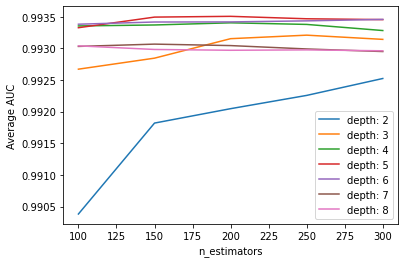

In [ ]:
X, Y = get_dataset('https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv')

stratified_k_fold_XGBoost(X, Y, n_folds=3)

## Grid search results with 4-fold CV


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting stratified Cross-validation using XG-Boost
Best: 0.993243 using {'max_depth': 4, 'n_estimators': 250}
acc = 0.951934 (0.006511) and f1 = 0.948348 (0.006743) and auc = 0.990595 (0.001268) with: {'max_depth': 2, 'n_estimators': 100}
acc = 0.954283 (0.004294) and f1 = 0.950891 (0.004409) and auc = 0.991725 (0.000933) with: {'max_depth': 2, 'n_estimators': 150}
acc = 0.955778 (0.006147) and f1 = 0.952555 (0.006442) and auc = 0.992061 (0.000836) with: {'max_depth': 2, 'n_estimators': 200}
acc = 0.957488 (0.005283) and f1 = 0.954410 (0.005464) and auc = 0.992248 (0.000804) with: {'max_depth': 2, 'n_estimators': 250}
acc = 0.957488 (0.004373) and f1 = 0.954384 (0.004507) and auc = 0.992406 (0.000842) with: {'max_depth': 2, 'n_estimators': 300}
acc = 0.956206 (0.005776) and f1 = 0.953008 (0.006062) and auc = 0.992537 (0.000951) with: {'max_depth': 3, 'n_estimators': 100}
acc = 0.958556 (0.005074) and f1 = 0.955510 (0.005386) and auc = 0.992921 (0.001002) with: {'max_depth': 3, 'n_esti

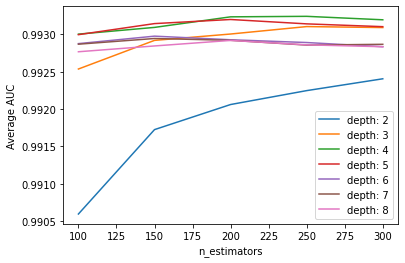

In [ ]:
X, Y = get_dataset('https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv')

stratified_k_fold_XGBoost(X, Y, n_folds=4)

## Grid search results with 5-fold CV


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting stratified Cross-validation using XG-Boost
Best: 0.993742 using {'max_depth': 3, 'n_estimators': 300}
acc = 0.952360 (0.002208) and f1 = 0.948725 (0.002302) and auc = 0.990861 (0.001780) with: {'max_depth': 2, 'n_estimators': 100}
acc = 0.955565 (0.003618) and f1 = 0.952145 (0.003805) and auc = 0.992086 (0.001274) with: {'max_depth': 2, 'n_estimators': 150}
acc = 0.955992 (0.004553) and f1 = 0.952619 (0.005098) and auc = 0.992615 (0.001299) with: {'max_depth': 2, 'n_estimators': 200}
acc = 0.957701 (0.005088) and f1 = 0.954482 (0.005622) and auc = 0.992946 (0.001078) with: {'max_depth': 2, 'n_estimators': 250}
acc = 0.958342 (0.004059) and f1 = 0.955255 (0.004440) and auc = 0.993185 (0.000865) with: {'max_depth': 2, 'n_estimators': 300}
acc = 0.958342 (0.003879) and f1 = 0.955318 (0.004245) and auc = 0.993289 (0.000862) with: {'max_depth': 3, 'n_estimators': 100}
acc = 0.958982 (0.003984) and f1 = 0.955885 (0.004452) and auc = 0.993560 (0.000559) with: {'max_depth': 3, 'n_esti

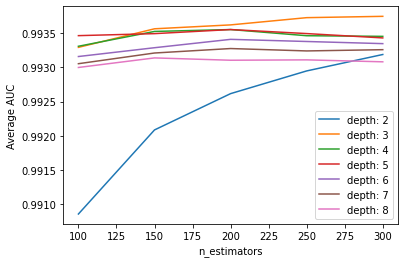

In [ ]:
X, Y = get_dataset('https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv')

stratified_k_fold_XGBoost(X, Y, n_folds=5)

## Grid search results with 10-fold CV

Starting stratified Cross-validation using XG-Boost



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Best: 0.993736 using {'max_depth': 3, 'n_estimators': 250}
acc = 0.953855 (0.006358) and f1 = 0.950424 (0.006549) and auc = 0.990820 (0.002056) with: {'max_depth': 2, 'n_estimators': 100}
acc = 0.955137 (0.005324) and f1 = 0.951818 (0.005439) and auc = 0.992079 (0.001840) with: {'max_depth': 2, 'n_estimators': 150}
acc = 0.957061 (0.005440) and f1 = 0.953866 (0.005683) and auc = 0.992658 (0.001631) with: {'max_depth': 2, 'n_estimators': 200}
acc = 0.958984 (0.005382) and f1 = 0.955839 (0.005942) and auc = 0.992834 (0.001622) with: {'max_depth': 2, 'n_estimators': 250}
acc = 0.958770 (0.006691) and f1 = 0.955621 (0.007292) and auc = 0.993155 (0.001644) with: {'max_depth': 2, 'n_estimators': 300}
acc = 0.958557 (0.005978) and f1 = 0.955515 (0.006424) and auc = 0.993117 (0.001587) with: {'max_depth': 3, 'n_estimators': 100}
acc = 0.960480 (0.006050) and f1 = 0.957590 (0.006538) and auc = 0.993543 (0.001466) with: {'max_depth': 3, 'n_estimators': 150}
acc = 0.961334 (0.006912) and f1 = 0.9

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

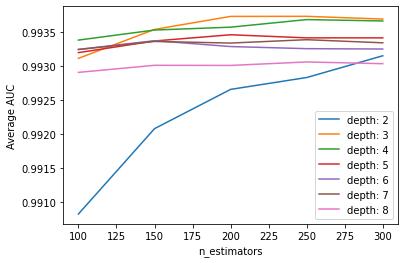

In [ ]:
X, Y = get_dataset('https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv')

stratified_k_fold_XGBoost(X, Y, n_folds=10)

## XGBoost preformance vs number of iterations

Size of Training:  4212
Size of Testing:  469
[0]	validation_0-error:0.140788	validation_0-logloss:0.589174	validation_1-error:0.172708	validation_1-logloss:0.598048
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[1]	validation_0-error:0.131766	validation_0-logloss:0.513028	validation_1-error:0.147122	validation_1-logloss:0.525033
[2]	validation_0-error:0.124406	validation_0-logloss:0.456849	validation_1-error:0.147122	validation_1-logloss:0.475965
[3]	validation_0-error:0.114435	validation_0-logloss:0.413024	validation_1-error:0.119403	validation_1-logloss:0.431245
[4]	validation_0-error:0.115859	validation_0-logloss:0.38132	validation_1-error:0.136461	validation_1-logloss:0.400776
[5]	validation_0-error:0.106363	validation_0-logloss:0.347733	validation_1-error:0.123667	validation_1-logloss:0.371292
[6]	validation_0-error:0.105888	validation_0-logloss:0.324767	validat


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[9]	validation_0-error:0.08642	validation_0-logloss:0.269398	validation_1-error:0.110874	validation_1-logloss:0.30024
[10]	validation_0-error:0.076448	validation_0-logloss:0.255169	validation_1-error:0.093817	validation_1-logloss:0.286225
[11]	validation_0-error:0.084995	validation_0-logloss:0.241901	validation_1-error:0.110874	validation_1-logloss:0.273672
[12]	validation_0-error:0.073837	validation_0-logloss:0.232246	validation_1-error:0.089552	validation_1-logloss:0.266027
[13]	validation_0-error:0.069563	validation_0-logloss:0.22069	validation_1-error:0.08742	validation_1-logloss:0.252329
[14]	validation_0-error:0.068851	validation_0-logloss:0.20929	validation_1-error:0.076759	validation_1-logloss:0.242598
[15]	validation_0-error:0.066239	validation_0-logloss:0.202547	validation_1-error:0.081023	validation_1-logloss:0.235274
[16]	validation_0-error:0.06434	validation_0-logloss:0.196377	validation_1-error:0.076759	validation_1-logloss:0.229823
[17]	validation_0-error:0.064577	valida

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

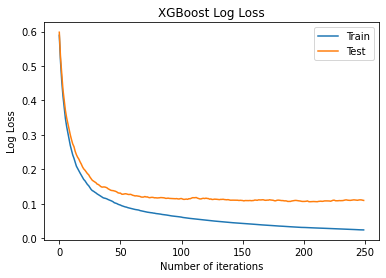

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

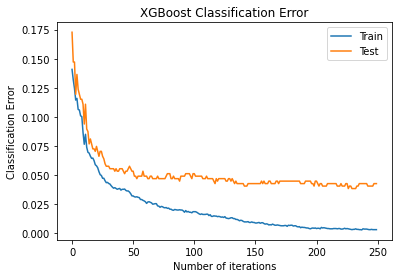

In [ ]:
X, Y = get_dataset('https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv')
X_train, X_test, y_train, y_test = prepare_dataset_split(X, Y, testSize=0.1)

XGBoost_Classifier (X_train, y_train, X_test, y_test)

## Confusion Matrix

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       251
           1       0.96      0.95      0.96       218

    accuracy                           0.96       469
   macro avg       0.96      0.96      0.96       469
weighted avg       0.96      0.96      0.96       469

Accuracy for model 2: 95.95
ROC:  0.9934939142512519
FALSE POSITIVES:  9
FALSE NEGATIVES:  10
Confusion matrix, without normalization
[[242   9]
 [ 10 208]]
242 9 10 208


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

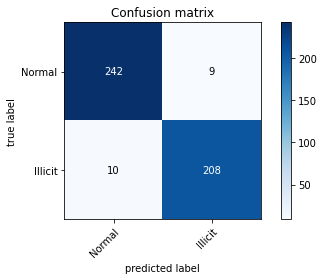

In [ ]:
importance = XGBoost(X_train, y_train, X_test, y_test)

# Feature Importance

In this section, we plot the first ten important features based on the theirs weights evaluated in XGBoost algorithm. We carry out the experiment for 10 times and use the average of the results to report the important features.

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Size of Training:  4212
Size of Testing:  469
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       251
           1       0.95      0.92      0.93       218

    accuracy                           0.94       469
   macro avg       0.94      0.94      0.94       469
weighted avg       0.94      0.94      0.94       469

Accuracy for model 2: 94.03
ROC:  0.9877371248949158
FALSE POSITIVES:  11
FALSE NEGATIVES:  17
[('Number_of_Created_Contracts', 1), ('ERC20_max_val_sent', 2), ('ERC20_uniq_sent_addr', 5), ('ERC20_uniq_rec_addr', 6), ('ERC20_avg_val_sent', 8), ('ERC20_min_val_sent', 11), ('ERC20_total_ether_sent', 13), ('ERC20_avg_val_rec', 13), ('ERC20_uniq_rec_contract_addr', 14), ('Unique_Sent_To_Addresses', 21), ('ERC20_max_val_rec', 22), ('Sent_tnx', 25), ('ERC20_total_Ether_received', 27), ('Total_ERC20_tnxs', 30), ('total_Ether_sent', 30), ('Received_Tnx', 33), ('ERC20_min_val_rec', 46), ('max_val_sent', 51), ('avg_val_sent', 52),

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

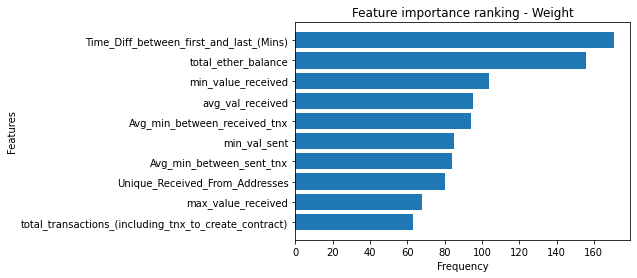

In [ ]:
X, Y = get_dataset('https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv')

importance_list = []
num_of_train_test_splits = 10

for i in range(num_of_train_test_splits):
  X_train, X_test, y_train, y_test = prepare_dataset_split(X, Y, testSize=0.1)
  importance = XGBoost(X_train, y_train, X_test, y_test)
  importance_list.extend(importance)
  sorted_feature_list = update_list(importance_list)

plot_average_importance_values(sorted_feature_list, num_of_train_test_splits)

# New experiments

In this section, we carry out new experiments to evaluate the performance of the model in different conditions. These conditions are as follows:


*   Tuning the learning rate (it was missed in the original paper)
*   Training the model with a portion of the dataset
*   Training the model with 10 most important features

We also compare the accuracy of the XGBoost with a model based on random forest.

## Hyper-parameter tuning including the learning rate

In [ ]:
def Learningrate_k_fold_XGBoost(X, Y, n_folds):
    X = X.loc[:, X.columns != 'Address']
    matplotlib.use('Agg')
    print("Starting stratified Cross-validation using XG-Boost")
    model1 = xgb.XGBClassifier()
    alpha = [0.1, 0.2, 0.3]
    max_depth = [2, 3, 4, 6]
    n_estimators = [200]
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,learning_rate=alpha )

    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=7)
    scoring = {'auc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'}
    current = time.time()
    results = GridSearchCV(model1, param_grid, cv=kfold, scoring=scoring, refit='auc', n_jobs=-1)
    grid_result = results.fit(X, Y)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means_auc = grid_result.cv_results_['mean_test_auc']
    means_acc = grid_result.cv_results_['mean_test_acc']
    means_f1 = grid_result.cv_results_['mean_test_f1']
    stds_auc = grid_result.cv_results_['std_test_auc']
    stds_acc = grid_result.cv_results_['std_test_acc']
    stds_f1 = grid_result.cv_results_['std_test_f1']
    params = grid_result.cv_results_['params']

    for mean_acc, std_acc, mean_f1, std_f1, mean_auc, std_auc, param in zip(means_acc, stds_acc, means_f1, stds_f1, means_auc, stds_auc, params):
      print('acc = %f (%f) and f1 = %f (%f) and auc = %f (%f) with: %r' % (mean_acc, std_acc, mean_f1, std_f1, mean_auc, std_auc, param))
    print('Execution time: ', time.time() - current)

    # plot results
    scores = np.array(means_auc).reshape(len(max_depth), len(alpha))
    for i, value in enumerate(max_depth):
        plt.plot(alpha, scores[i], label='depth: ' + str(value))
    plt.legend()
    plt.xlabel('alpha')
    plt.ylabel('Average AUC')
    #plt.savefig('Figure_3.pdf', format='pdf', bbox_inches='tight')
    #files.download('Figure_3.pdf')
    plt.show()

Starting stratified Cross-validation using XG-Boost


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Best: 0.993735 using {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
acc = 0.952146 (0.006212) and f1 = 0.948524 (0.006296) and auc = 0.990731 (0.001942) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
acc = 0.958983 (0.005214) and f1 = 0.956022 (0.005590) and auc = 0.993224 (0.001419) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
acc = 0.957277 (0.008253) and f1 = 0.954140 (0.009047) and auc = 0.993562 (0.001481) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
acc = 0.959625 (0.010306) and f1 = 0.956695 (0.010974) and auc = 0.993276 (0.001454) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
acc = 0.957061 (0.005440) and f1 = 0.953866 (0.005683) and auc = 0.992658 (0.001631) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200}
acc = 0.961334 (0.006912) and f1 = 0.958559 (0.007480) and auc = 0.993735 (0.001479) with: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
acc = 0.96112

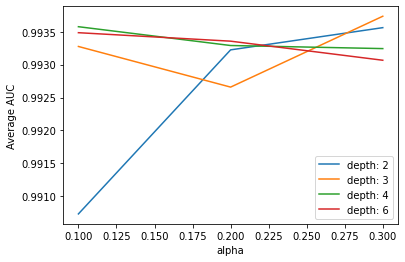

In [ ]:
X, Y = get_dataset('https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv')

Learningrate_k_fold_XGBoost(X, Y, n_folds=10)

## A portion of dataset considered

In [ ]:
def get_no_of_dataset(url, number):
    import pandas as pd
    import random
    csv_file_url = url
    df = pd.read_csv(csv_file_url)
    index1=[]
    index2=[]
    index=[]

    for i,label in enumerate(df['FLAG']):
      if label==1:
        index1.append(i)

      else:
        index2.append(i)
    index.extend(random.sample(index1, number//2))
    index.extend(random.sample(index2, number//2))
    Y = df.loc[index, df.columns=='FLAG']
    X = df.loc[index, df.columns != 'FLAG']
    X.pop('Index')
    X.pop('ERC20_most_sent_token_type')
    X.pop('ERC20_most_rec_token_type')
    X.pop('ERC20_uniq_sent_token_name')
    X.pop('ERC20_uniq_rec_token_name')
    #X.pop('Address')

    X.fillna(0, inplace=True)
    return X, Y

Starting stratified Cross-validation using XG-Boost


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: 0.993610 using {'max_depth': 4, 'n_estimators': 250}
acc = 0.947000 (0.009798) and f1 = 0.946974 (0.009583) and auc = 0.989805 (0.003712) with: {'max_depth': 2, 'n_estimators': 100}
acc = 0.954000 (0.008888) and f1 = 0.953964 (0.008772) and auc = 0.991530 (0.003154) with: {'max_depth': 2, 'n_estimators': 150}
acc = 0.952500 (0.012093) and f1 = 0.952547 (0.011461) and auc = 0.991930 (0.003106) with: {'max_depth': 2, 'n_estimators': 200}
acc = 0.953000 (0.010770) and f1 = 0.953059 (0.010258) and auc = 0.992330 (0.002762) with: {'max_depth': 2, 'n_estimators': 250}
acc = 0.954000 (0.009950) and f1 = 0.954031 (0.009528) and auc = 0.992380 (0.002740) with: {'max_depth': 2, 'n_estimators': 300}
acc = 0.955000 (0.012845) and f1 = 0.955211 (0.012264) and auc = 0.992450 (0.002613) with: {'max_depth': 3, 'n_estimators': 100}
acc = 0.953000 (0.010536) and f1 = 0.953171 (0.009864) and auc = 0.992720 (0.002031) with: {'max_depth': 3, 'n_estimators': 150}
acc = 0.953500 (0.009760) and f1 = 0.9

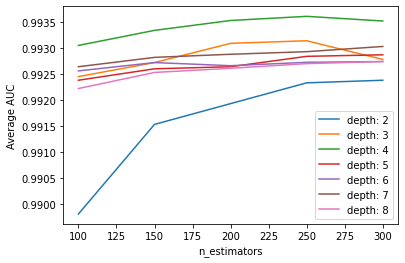

In [ ]:
url='https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv'
X, Y = get_no_of_dataset(url, 2000)
stratified_k_fold_XGBoost(X, Y, n_folds=10)

## Only top 10 features considered

In [ ]:
def get_dataset(url):
    import pandas as pd

    csv_file_url = url
    df = pd.read_csv(csv_file_url)

    Y = df['FLAG']
    X = df.loc[:, ['total_transactions_(including_tnx_to_create_contract)','max_value_received','Unique_Received_From_Addresses','Avg_min_between_sent_tnx','min_val_sent' , 'Avg_min_between_received_tnx', 'avg_val_received','min_value_received', 'total_ether_balance', 'Time_Diff_between_first_and_last_(Mins)']]
    X.fillna(0, inplace=True)
    return X, Y

Starting stratified Cross-validation using XG-Boost
Best: 0.989619 using {'max_depth': 3, 'n_estimators': 250}
acc = 0.943816 (0.004868) and f1 = 0.939843 (0.005366) and auc = 0.986785 (0.002183) with: {'max_depth': 2, 'n_estimators': 100}
acc = 0.946380 (0.004997) and f1 = 0.942545 (0.005401) and auc = 0.987957 (0.001777) with: {'max_depth': 2, 'n_estimators': 150}
acc = 0.945952 (0.003179) and f1 = 0.942058 (0.003473) and auc = 0.988595 (0.001550) with: {'max_depth': 2, 'n_estimators': 200}
acc = 0.948087 (0.004976) and f1 = 0.944392 (0.005515) and auc = 0.988813 (0.001671) with: {'max_depth': 2, 'n_estimators': 250}
acc = 0.947446 (0.007544) and f1 = 0.943747 (0.008176) and auc = 0.989072 (0.001785) with: {'max_depth': 2, 'n_estimators': 300}
acc = 0.948302 (0.004139) and f1 = 0.944948 (0.004392) and auc = 0.988979 (0.001491) with: {'max_depth': 3, 'n_estimators': 100}
acc = 0.949369 (0.007092) and f1 = 0.945954 (0.007514) and auc = 0.989458 (0.001748) with: {'max_depth': 3, 'n_esti

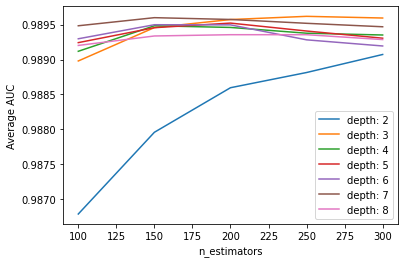

In [ ]:
url='https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv'
X, Y = get_dataset(url)
stratified_k_fold_XGBoost(X, Y, n_folds=10)

## Comparison with random forest

In [ ]:
X, Y = get_dataset('https://raw.githubusercontent.com/sfarrugia15/Ethereum_Fraud_Detection/master/Account_Stats/Complete.csv')

X_train, X_test, y_train, y_test = prepare_dataset_split(X, Y, testSize=0.1)
random_forest(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Size of Training:  4212
Size of Testing:  469
Accuracy for Random Forest Model: 93.82
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       251
           1       0.94      0.92      0.93       218

    accuracy                           0.94       469
   macro avg       0.94      0.94      0.94       469
weighted avg       0.94      0.94      0.94       469

ROC: 0.9905515552469023
